# Highway Environment

Let's look at the highway environment https://github.com/Farama-Foundation/HighwayEnv

Set up the environment by adding the submodule to this folder.

Setup the environment by calling 

```
cd HighwayEnv
conda activate q-learning
python setup develop
```

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import gymnasium as gym
import numpy as np
np.set_printoptions(suppress=True)
import math
import random
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from pprint import pprint


# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Let's define the gymnasium environment, and see what we can do in it.

We define observations according to the definition in https://highway-env.readthedocs.io/en/latest/observations/index.html

We have the observation parameters 
- `presence` (Whether vehicle is visible in view)
- `x`
- `y`
- `vx`
- `vy`
- `cos_h`
- `sin_h`

In [109]:
env = gym.make('highway-v0', render_mode='rgb_array')

config = {
    "observation": {
        "type": "Kinematics",
        "vehicles_count": 15,
        "features": ["presence", "x", "y", "vx", "vy", "cos_h", "sin_h"],
        "features_range": {
            "x": [-100, 100],
            "y": [-100, 100],
            "vx": [-20, 20],
            "vy": [-20, 20]
        },
        "absolute": False,
        "order": "sorted"
    },
    "duration": 20,
    "vehicles_count": 20,
    "collision_reward": -1,
    "high_speed_reward": 0.4
}

env.configure(config)

pprint(env.config)

{'action': {'type': 'DiscreteMetaAction'},
 'centering_position': [0.3, 0.5],
 'collision_reward': -1,
 'controlled_vehicles': 1,
 'duration': 20,
 'ego_spacing': 2,
 'high_speed_reward': 0.4,
 'initial_lane_id': None,
 'lane_change_reward': 0,
 'lanes_count': 4,
 'manual_control': False,
 'normalize_reward': True,
 'observation': {'absolute': False,
                 'features': ['presence',
                              'x',
                              'y',
                              'vx',
                              'vy',
                              'cos_h',
                              'sin_h'],
                 'features_range': {'vx': [-20, 20],
                                    'vy': [-20, 20],
                                    'x': [-100, 100],
                                    'y': [-100, 100]},
                 'order': 'sorted',
                 'type': 'Kinematics',
                 'vehicles_count': 15},
 'offroad_terminal': False,
 'offscreen_rendering': Fa

/home/aai/anaconda3/envs/q-learning/lib/python3.8/site-packages/gymnasium/utils/passive_env_checker.py:42: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (5, 5)
  logger.warn(


Lets see, which actions we can perform

In [110]:
print(list(env.action_type.actions_indexes.keys()))

['LANE_LEFT', 'IDLE', 'LANE_RIGHT', 'FASTER', 'SLOWER']


In [111]:
def get_action(obs):
    distances_to_vehicles = np.linalg.norm(obs[:,1:2],axis=1)
    if distances_to_vehicles[obs[:,0] > 0].min() < 0.15:
        action = env.action_type.actions_indexes["SLOWER"]
        print(f"SLOWER: {distances_to_vehicles[obs[:,0] > 0].min()}")
    else:
        action = env.action_type.actions_indexes["FASTER"]
        print(f"FASTER: {distances_to_vehicles[obs[:,0] > 0].min()}")
    return action

In [112]:
obs, info = env.reset()
for _ in range(30):
    obs, reward, done, truncated, info = env.step(get_action(obs))
    env.render()
env.close()

FASTER: 0.22860531508922577
FASTER: 0.16660159826278687
SLOWER: 0.06791802495718002
SLOWER: 0.015495242550969124
SLOWER: 0.05618380382657051
SLOWER: 0.07327571511268616
SLOWER: 0.08571264147758484
SLOWER: 0.09643597900867462
FASTER: 0.2049071490764618
FASTER: 0.20152637362480164
FASTER: 0.15337350964546204
SLOWER: 0.08153873682022095
SLOWER: 0.030872169882059097
SLOWER: 0.025245536118745804
SLOWER: 0.04354032874107361
SLOWER: 0.06577606499195099
SLOWER: 0.08851192146539688
SLOWER: 0.11114273965358734
SLOWER: 0.13355320692062378
SLOWER: 0.14697128534317017
FASTER: 0.15184777975082397
SLOWER: 0.13167503476142883
SLOWER: 0.11607901751995087
SLOWER: 0.1176508441567421
SLOWER: 0.12221099436283112
SLOWER: 0.1273345947265625
SLOWER: 0.13260595500469208
SLOWER: 0.13795307278633118
SLOWER: 0.14336296916007996
SLOWER: 0.1488330215215683


In [113]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

Let's use the same network architecture as for the [Cart-Pole](https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html) example. However, we need to increase the parameter number to accommodate for the increased state and action space. 

In [114]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, 256)
        self.layer4 = nn.Linear(256, 128)
        self.layer5 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        x = F.relu(self.layer4(x))
        return self.layer5(x)

In [115]:
def mask_state(state):
    '''
        Since the state space for all 20 vehicles in the scene is enormous (20*7 = 140) we need to reduce the number drastically
        We will consider only the four closest vehicles for now  
    '''
    return state[:4].flatten()

In [116]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the AdamW optimizer
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
n_observations = len(mask_state(state))

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)


episode_durations = []
episode_reward = []


def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [117]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

The reward function for the `highway-v0` setting is defined as (https://highway-env.readthedocs.io/en/latest/rewards/index.html):

$
    R(s,a) = w_{velo}\frac{v-v_{min}}{v_{max}-v_{min}} - w_{col}~\text{collision}
$

with $v, v_{min}, v_{max}$ being the current, minimal and maximal speed of the vehicle, $w_{velo}$ is the weight of the ego speed in the reward and $w_{col}$ is the weight of a collision of the ego vehicle with another vehicle in the reward.

Complete


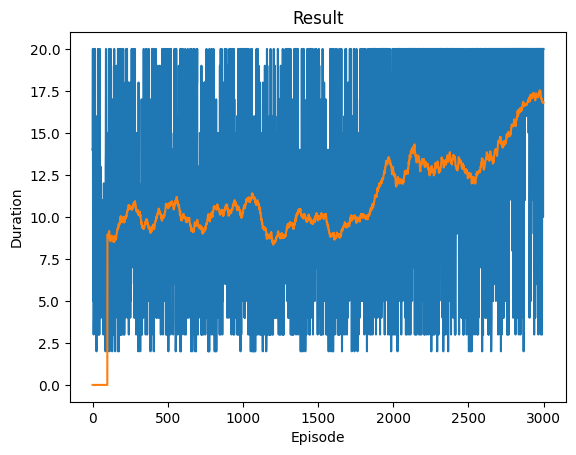

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [130]:
if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 50
    
for i_episode in range(num_episodes):
    # Initialize the environment and get it's state
    state, info = env.reset()
    state = torch.tensor(mask_state(state), dtype=torch.float32, device=device).unsqueeze(0)
    mean_reward = list()
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        mean_reward.append(reward.copy())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(mask_state(observation), dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            episode_reward.append(np.mean(mean_reward))
            plot_durations()
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

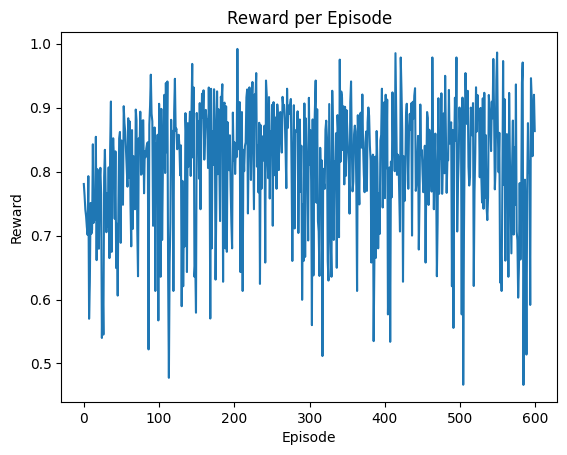

In [119]:
plt.plot(np.arange(len(episode_reward)), episode_reward)
plt.title("Reward per Episode")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.show()

We use the target network, which is a momentum based updated version of the policy network for the prediction. It's predictions are more stable

In [131]:
state, info = env.reset()
state = torch.tensor(mask_state(state), dtype=torch.float32, device=device).unsqueeze(0)
MAX_ITERATIONS = 100
for i in range(MAX_ITERATIONS):
    action = target_net(state).argmax(0)
    print(f"Action: {list(env.action_type.actions_indexes.keys())[action]}")
    observation, reward, terminated, truncated, _ = env.step(action.item())
    env.render()
    next_state = torch.tensor(mask_state(observation), dtype=torch.float32, device=device).unsqueeze(0)
    # Move to the next state
    state = next_state
    done = terminated or truncated
    if done:
        break
env.close()
    

TypeError: only integer tensors of a single element can be converted to an index